In [9]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore", category=UserWarning,
                        message="pandas only supports SQLAlchemy connectable")

try:
    print("\033[95mconnection to database...")
    conn = psycopg2.connect(
        database='piscineds',
        user='bgales',
        password='mysecretpassword',
        host='localhost'
    )
    cursor = conn.cursor()
    print('\033[92mconnection with database OK')
    table_name="customers"
    cursor.execute('BEGIN;')

except Exception as e:
    print("\033[91mError: ", e)
    print('\033[93mrollback in progress...\033[0m')
    conn.rollback()

connection to database...
connection with database OK


In [10]:
def hide_ticks_frame(ax):
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().set_facecolor('#EAEAF2')

In [11]:
try:
    print('\033[93mfetching data from database for graph one...\033[0m')
    df = []
    df.append(pd.read_sql(
        f'''
            SELECT DATE(event_time AT TIME ZONE 'UTC') AS event_date,
                COUNT (DISTINCT user_id) as daily_customer_count
            FROM {table_name}
            WHERE event_type = 'purchase'
            GROUP by event_date
        ''', conn))
    print('\033[92mdata fetched with success!\033[0m')
    print('\033[93mfetching data from database for graph two...\033[0m')
    df.append(pd.read_sql_query(
        f'''
            SELECT TO_CHAR(event_time AT TIME ZONE 'UTC', 'YYYY-MM')
                AS event_date,
                SUM (price) as daily_income
            FROM {table_name}
            WHERE event_type = 'purchase'
            GROUP by event_date
        ''', conn)
    )
    print('\033[92mdata fetched with success!\033[0m')
    print('\033[93mfetching data from database for graph three...\033[0m')
    df.append(pd.read_sql(
        '''
            SELECT DATE(event_time AT TIME ZONE 'UTC') AS event_date,
                SUM (price) / COUNT(DISTINCT user_id) AS average_spent
            FROM customers
            WHERE event_type = 'purchase'
            GROUP BY event_date
        ''', conn)
    )
    print('\033[92mdata fetched with success!\033[0m')
except Exception as e:
    print("\033[91mError: ", e)
    print('\033[93mrollback in progress...\033[0m')
    conn.rollback()

fetching data from database for graph one...
data fetched with success!
fetching data from database for graph two...
data fetched with success!
fetching data from database for graph three...
data fetched with success!


displaying graph one...


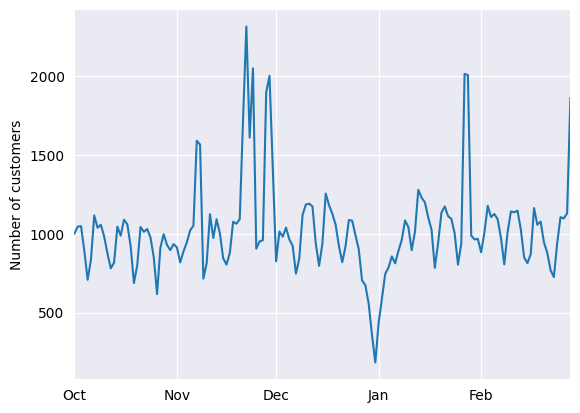

In [12]:
fig, ax = plt.subplots()
ax.plot(df[0]['event_date'], df[0]['daily_customer_count'])
plt.ylabel('Number of customers')

# format YYYY-MM-DD into months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# evite la duplication des mois sur les labels axe y
ax.xaxis.set_major_locator(mdates.MonthLocator())

# remove march from labels
plt.setp(ax.get_xticklabels()[-1], visible=False)

# remove ticks and frame
hide_ticks_frame(ax)

print('\033[2mdisplaying graph one...\033[0m')
plt.grid(color='white', linestyle='-')
plt.xlim(df[0]['event_date'].min(), df[0]['event_date'].max())
plt.show()

displaying graph two...


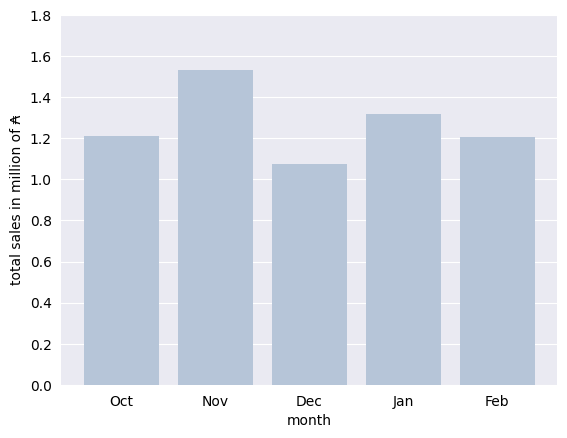

In [13]:
fig, ax = plt.subplots()
plt.bar(df[1]['event_date'], df[1]['daily_income'],
        color='#B6C5D8', alpha=1, zorder=2)
months_label = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb']
hide_ticks_frame(ax)
plt.ylabel('total sales in million of ₳')
plt.xlabel('month')
ax.set_xticks(range(len(months_label)))
ax.set_xticklabels(months_label)

# remove awful scientific notation indicator from chart
ax.set_yticks(ax.get_yticks())

ax.set_yticklabels([f'{v / 1e6:.1f}' for v in ax.get_yticks()])
print('\033[2mdisplaying graph two...\033[0m')
plt.grid(axis='y', color='white', linestyle='-', zorder=0)
plt.show()

displaying graph three...


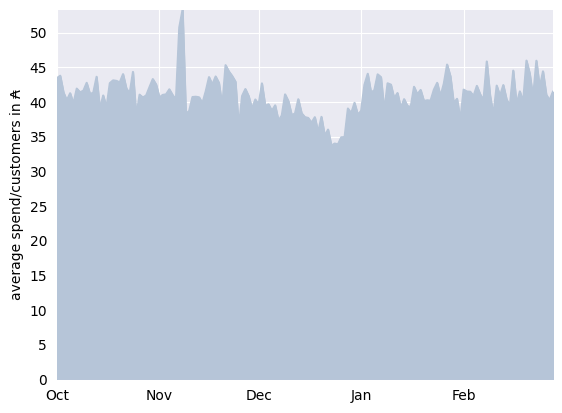

closing connection with database...


In [14]:
fig, ax = plt.subplots()
ax.plot(df[2]['event_date'], df[2]['average_spent'],
        color='#B6C5D8', alpha=1, zorder=2)
ax.set_ylim(0, df[2]['average_spent'].max())
plt.ylabel('average spend/customers in ₳')

# format YYYY-MM-DD into months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# remove march from labels
plt.setp(ax.get_xticklabels()[-1], visible=False)
plt.fill_between(df[2]['event_date'], df[2]['average_spent'],
                 color='#B6C5D8', alpha=1, zorder=2)
# remove ticks and frame
hide_ticks_frame(ax)

print('\033[2mdisplaying graph three...\033[0m')
plt.xlim(df[2]['event_date'].min(), df[2]['event_date'].max())
plt.yticks(np.arange(0, df[2] ['average_spent'].max(), 5))
plt.grid(color='white', linestyle='-', zorder=0)
plt.show()

if conn:
    print("\033[95mclosing connection with database...")
    cursor.close()
    conn.close()